In [1]:
%matplotlib inline

import tensorflow as tf
print("TensorFlow", tf.__version__)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import (ResNet152, preprocess_input, 
                                                  decode_predictions)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, 
                                     GlobalAveragePooling2D)
import tensorflow.keras.backend as K

from keras.preprocessing.image import ImageDataGenerator

import cv2
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil

from tqdm import tqdm
from scipy.stats import mode

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

BASE = "gdrive/My Drive/"

TensorFlow 2.2.0-rc3


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
IMG_SIZE = (224, 224, 3)

input_ = Input(IMG_SIZE)

resnet152 = ResNet152(weights="imagenet", input_tensor=input_, 
                      input_shape=IMG_SIZE, include_top=True)

242900992/242900224 [==============================] - 2s 0us/step


In [0]:
test_img_paths = os.listdir(f"{BASE}test_images")

test_imgs = [image.load_img(f"{BASE}test_images/{p}", target_size=(224, 224))
             for p in test_img_paths]

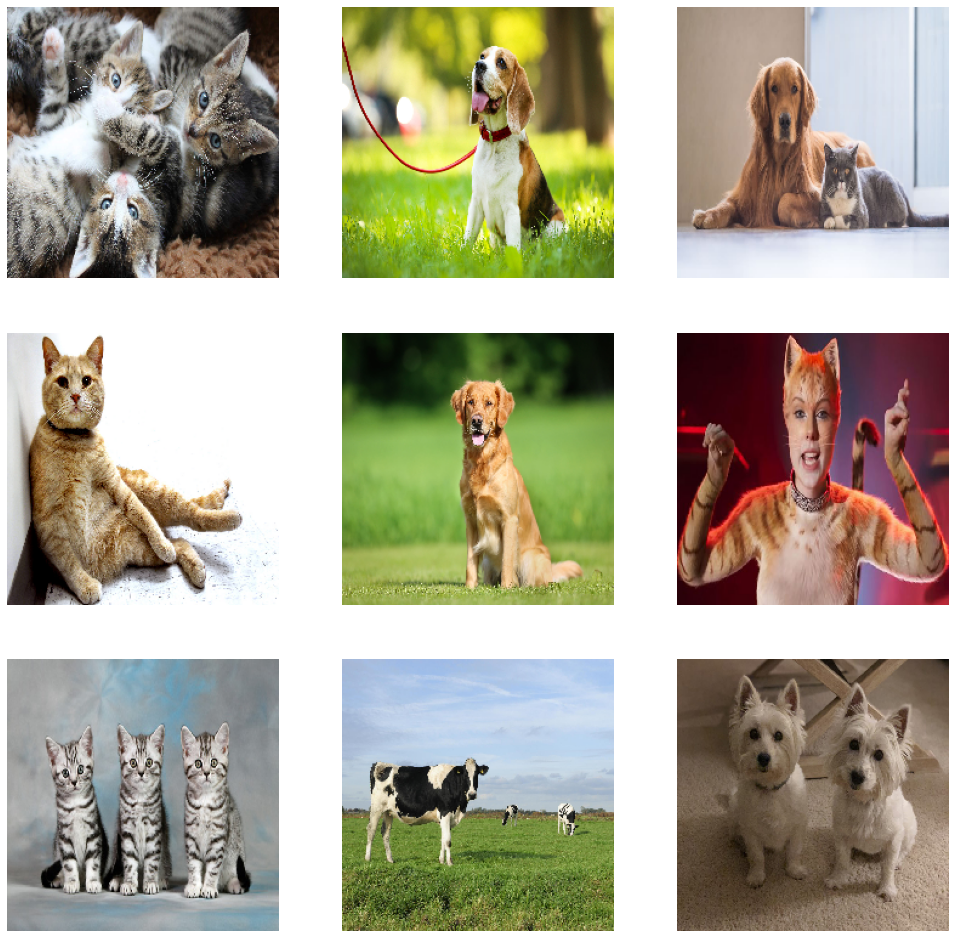

In [53]:
fig, ax = plt.subplots(3, 3, figsize=(17, 17))
for k in range(9):
    i = k // 3
    j = k % 3
    ax[i, j].imshow(test_imgs[k])
    ax[i, j].axis("off")

# CAM

In [0]:
def get_CAM(model, img, class_idx=None):

    # Computes CAM as the ponderated sum of convolutional output maps.

    # extract the finally dense layer weights for the given class
    class_weights = model.layers[-1].get_weights()[0]
    # get the appropriate layer, could be passed in as a parameter but for now
    # we will just focus on the final convolutional layer
    conv_layer = model.get_layer("conv5_block3_out")
    get_output = K.function([model.input], [conv_layer.output, model.output])

    conv_outputs, preds = get_output(np.expand_dims(img, axis=0))
    conv_outputs = conv_outputs[0]

    if class_idx is None:
        class_idx = np.argmax(preds, axis=1)

    # instantiate an empty cam grid and populate with the ponderated sum
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam += w * conv_outputs[:, :, i]

    return cam, preds

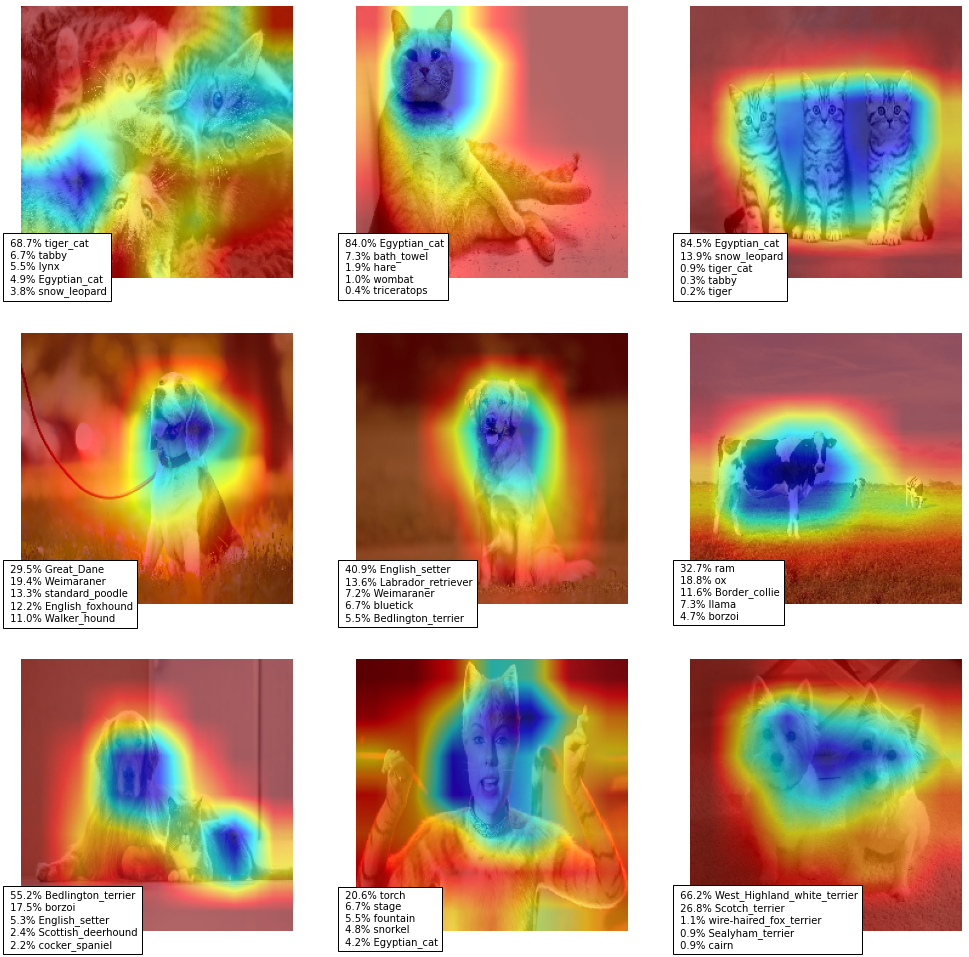

In [71]:
fig, axes = plt.subplots(3, 3, figsize=(17, 17))
for k in range(9):
    i = k // 3
    j = k % 3
    ax = axes[i, j]
    test_img = test_imgs[k]

    cam, preds = get_CAM(resnet152, test_img)

    # scale the grid, resize it and apply a colourmap
    heatmap = np.maximum(cam, 0) / np.max(cam)
    heatmap = (255 * cv2.resize(heatmap, (224, 224))).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # create the superimposed image
    superimposed_img = (heatmap*0.6 + 0.4*image.img_to_array(test_img)).astype(int)

    axes[i, j].imshow(superimposed_img)
    preds = decode_predictions(preds)[0]
    text = "\n".join([f" {round(100*conf, 1)}% {label}" for _, label, conf in preds])
    ax.text(-.05, .15, text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(facecolor="white"))
    ax.axis("off")

# Guided Backpropagation

In [0]:
# This function is a modified version of a function from 
# https://stackoverflow.com/a/54517478
def insert_layer_nonseq(model, layer_regex, insert_layer_factory,
                        insert_layer_name=None):

    # Insert a layer from layer_factory into the network after matching the 
    # regex. It is slightly more complicated for non-sequential models (like our
    # ResNet152) as node outputs might point to more than one node input.

    # Auxiliary dictionary to describe the network graph
    network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer.outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                if layer.name not in network_dict['input_layers_of'][layer_name]:
                    network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if re.match(layer_regex, layer.name):
            x = layer(layer_input)
            new_layer_name = str.replace(layer.name, "relu", "gbpg")
            new_layer = insert_layer_factory(new_layer_name)
            x = new_layer(x)

        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

    return Model(inputs=model.inputs, outputs=x)

In [0]:
@tf.custom_gradient
def guided_bpg_gate(x):
    # op for GuidedBpgGate with custom guided gradients
    def grad(dy):
        return dy * tf.cast(dy > 0., x.dtype) 
    return tf.identity(x), grad

class GuidedBpgGate(tf.keras.layers.Layer):

    # Custom layer that does nothing on a forward pass but blocks negative
    # gradients on a backwards pass.

    def __init__(self, **kwargs):
        super(GuidedBpgGate, self).__init__(**kwargs)

    def call(self, x):
        return guided_bpg_gate(x)

def layer_factory(name):
    return GuidedBpgGate(name=name)

def guided_bpg(model, imgs, class_idx=None):

    # Return a Guided Backpropagation image reconstruction.

    # get one-hot labels
    num_classes = model.output.shape[1]

    # calculate loss inside GradientTape context manager
    with tf.GradientTape() as tape:
        inputs = tf.cast(imgs, tf.float32)
        tape.watch(inputs)
        preds = model(inputs)

        if class_idx is None:
            class_idx = np.argmax(preds, axis=1)

        labels = tf.reshape(tf.one_hot([class_idx], num_classes), (-1, 1000))
        loss = tf.keras.losses.categorical_crossentropy(labels, preds)

    # return back propagated gradients
    return tape.gradient(loss, inputs), preds

In [21]:
# create the model with added GuidedBpgGates
gbpgResnet152 = insert_layer_nonseq(resnet152, ".*relu", layer_factory)
# to coerce the graph into reconstructing we have to save and reload the model
gbpgResnet152.save("model")
gbpgResnet152 = tf.keras.models.load_model("model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


(1, 9, 1000)
(9, 1000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


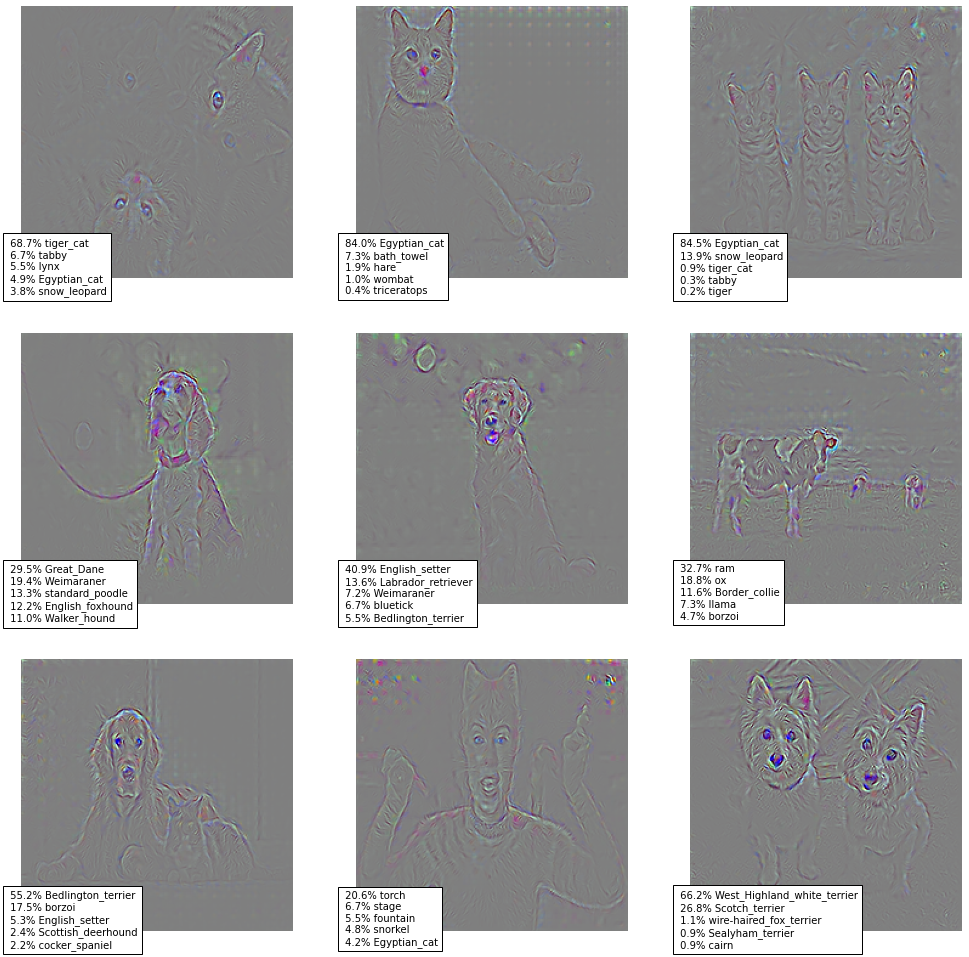

In [84]:
ggs, preds = guided_bpg(gbpgResnet152, 
                        [image.img_to_array(i) for i in test_imgs[:9]])
preds = decode_predictions(preds.numpy())

fig, axes = plt.subplots(3, 3, figsize=(17, 17))
for k in range(9):
    i = k // 3
    j = k % 3
    ax = axes[i, j]

    gg = ggs[k]

    ax.imshow((gg / np.max(gg))+0.5)
    text = "\n".join([f" {round(100*conf, 1)}% {label}" for _, label, conf in preds[k]])
    ax.text(-.05, .15, text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(facecolor="white"))
    ax.axis("off")

# Occlusion Sensitivity

In [0]:
def get_OSM(model, img, class_idx=None, n_patches=7, just_the_batch=False):
    def get_patched_batch():

        size = img.shape[0] // n_patches

        def patch(x, y):
            patched = img.copy()
            patched[y*size:(y+1)*size, x*size:(x+1)*size, :] = 128
            return patched

        batch = []
        for x in range(n_patches):
            for y in range(n_patches):
                batch.append(patch(x, y))

        return np.array(batch)

    batch = get_patched_batch()

    if just_the_batch:
        return batch

    preds = model(batch)
    if class_idx is None:
        class_idx = mode(np.argmax(preds, axis=1), axis=None).mode[0]
    conf_grid = preds[:, class_idx]\
                    .numpy()\
                    .reshape((n_patches, n_patches))

    return conf_grid, tf.reduce_mean(preds, 0)

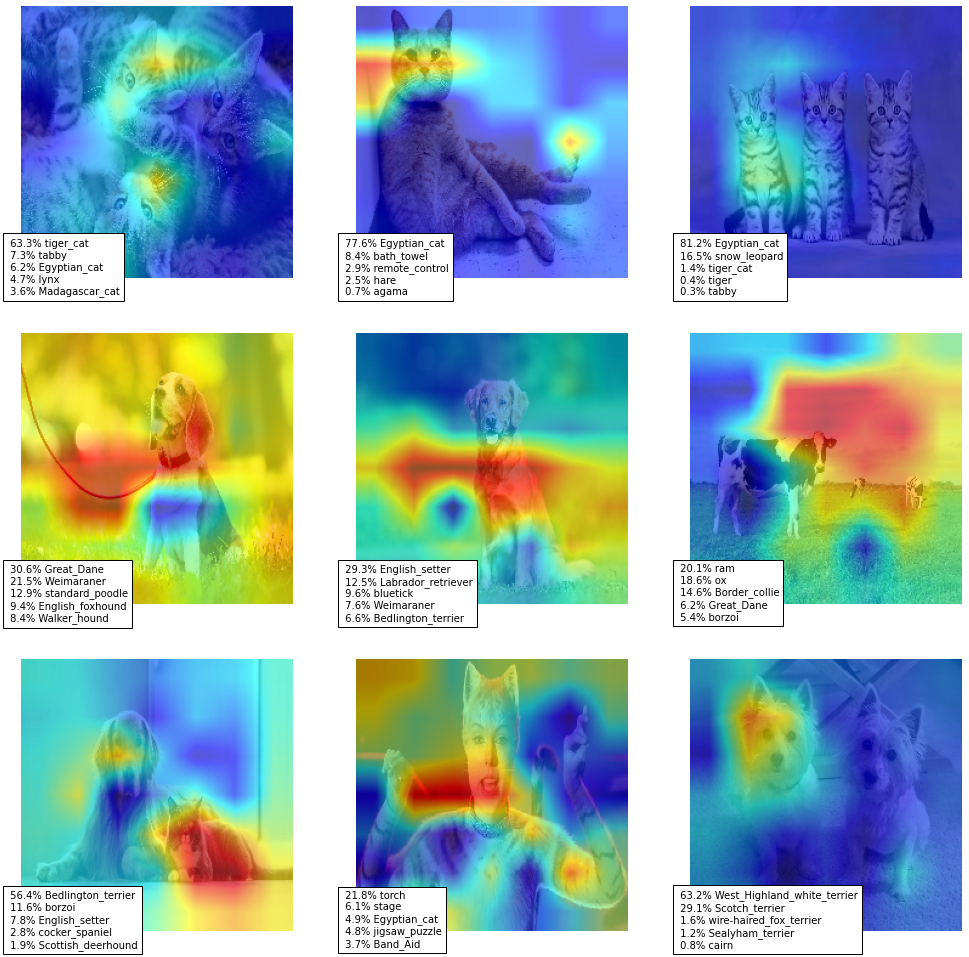

In [105]:
fig, axes = plt.subplots(3, 3, figsize=(17, 17))
for k in range(9):
    i = k // 3
    j = k % 3
    ax = axes[i, j]
    test_img = image.img_to_array(test_imgs[k])

    osm, preds = get_OSM(resnet152, test_img)

    heatmap = np.maximum(osm, 0) / np.max(osm)
    heatmap = (255 * cv2.resize(heatmap, (224, 224))).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = (heatmap*0.6 + test_img*0.4).astype(int)

    preds = preds.numpy().reshape((1, 1000))
    preds = decode_predictions(preds)[0]

    ax.imshow(superimposed_img)
    text = "\n".join([f" {round(100*conf, 1)}% {label}" for _, label, conf in preds])
    ax.text(-.05, .15, text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(facecolor="white"))
    ax.axis("off")


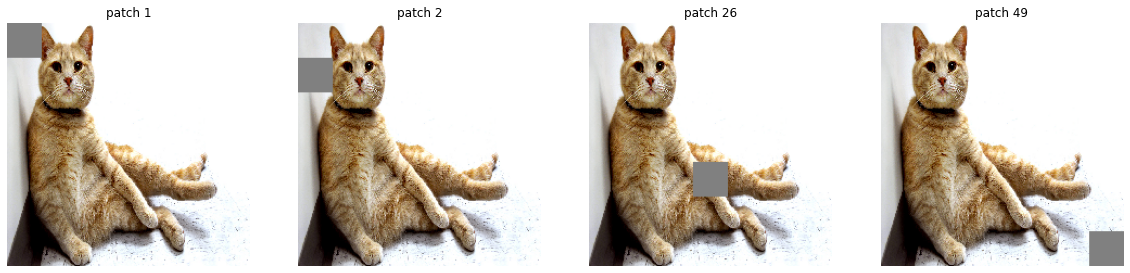

In [115]:
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
patched_batch = get_OSM(resnet152, image.img_to_array(test_imgs[1]), 
                        just_the_batch=True)
display_idxs = [0, 1, 25, 48]
for k in range(4):
    ax = axes[k]
    ax.imshow(patched_batch[display_idxs[k]].astype(int))
    ax.set_title(f"patch {display_idxs[k]+1}")
    ax.axis("off")

# Misc Experiments

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


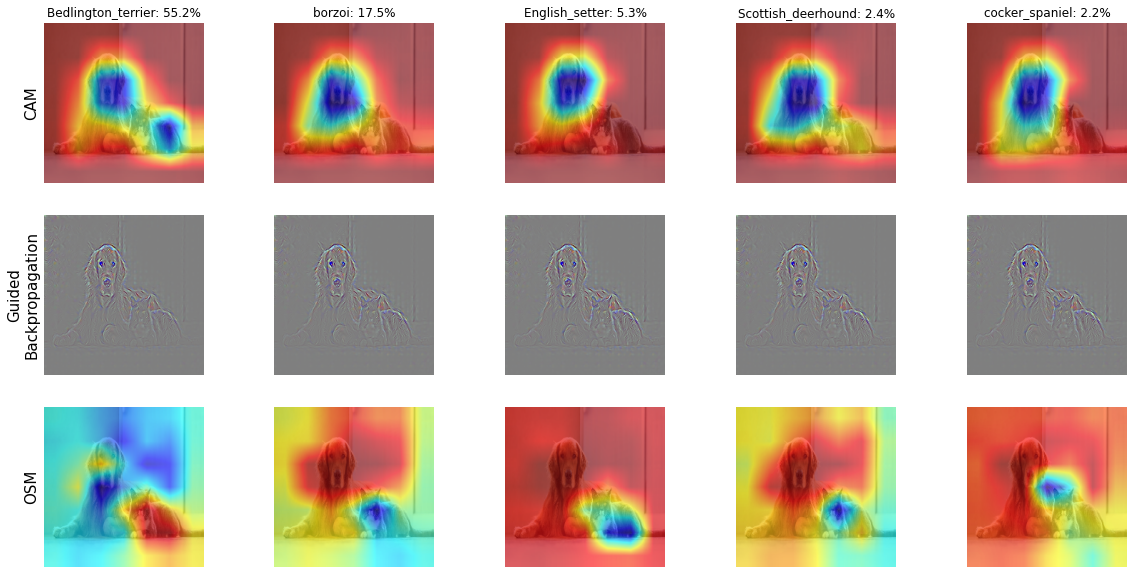

In [65]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
test_img = test_imgs[4]
preds = resnet152(np.expand_dims(test_img, 0)).numpy()
idxs = np.argsort(preds, axis=1)[0, :-6:-1]
preds = decode_predictions(preds)

axes[0, 0].set_ylabel("CAM", fontsize=15)
axes[1, 0].set_ylabel("Guided\nBackpropagation", fontsize=15)
axes[2, 0].set_ylabel("OSM", fontsize=15)

for j, idx in enumerate(idxs):

    _, label, conf = preds[0][j]
    axes[0, j].set_title(f"{label}: {round(100*conf, 1)}%")

    cam, _ = get_CAM(resnet152, test_img, idx)
    heatmap = np.maximum(cam, 0) / np.max(cam)
    heatmap = (255 * cv2.resize(heatmap, (224, 224))).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = (heatmap*0.6 + 0.4*image.img_to_array(test_img)).astype(int)
    axes[0, j].imshow(superimposed_img)
    axes[0, j].set_frame_on(False)
    axes[0, j].set_yticks([])
    axes[0, j].set_xticks([])

    gg, _ = guided_bpg(gbpgResnet152, np.expand_dims(test_img, 0), idx)
    axes[1, j].imshow((gg[0] / np.max(gg))+0.5)
    axes[1, j].set_frame_on(False)
    axes[1, j].set_yticks([])
    axes[1, j].set_xticks([])

    osm, _ = get_OSM(resnet152, image.img_to_array(test_img), idx)
    heatmap = np.maximum(osm, 0) / np.max(osm)
    heatmap = (255 * cv2.resize(heatmap, (224, 224))).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = (heatmap*0.6 + image.img_to_array(test_img)*0.4).astype(int)
    axes[2, j].imshow(superimposed_img)
    axes[2, j].set_frame_on(False)
    axes[2, j].set_yticks([])
    axes[2, j].set_xticks([])
